# CNN Cancer Detection

---

## 1- Introduction

The goal of this project is to use Deep Learning to identify whether a given RGB image patch with dimensions 96x96 pixels is displaying metastatic cancer tumors at the center or not (binary classification). The images are sourced from the Kaggle competition titled "[Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)". The kaggle page claims the dataset contains no duplicates. The dataset is already split into training and testing subsets. The 220,025 Training images are labled while the label for the 57,458 testing images are to be predicted. Evaluation is performed by predicting the probability that the center 32x32 pixel region of a given patch contains at least one pixel of tumor tissue, and then calculating the area under the ROC curve between the predicted probabilityes and the observed target.



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from PIL import Image
import cv2
import random
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, models
mixed_precision.set_global_policy("mixed_float16")
print(keras.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6
2.10.0


In [2]:
# import data
train_labels = pd.read_csv('data/train_labels.csv')
train_path = 'data/train_png'
test_path = 'data/test_png'

In [3]:
train_labels.shape

(220025, 2)

In [4]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The file **train_labels.csv** contains two columns; the first column contains the **id**, which is the same as the file name of a given image and the second column contains labels, indicating if a given image shows metastatic tumors. This csv file has 220,025 rows, as there are the same number of training images.

## 2- EDA

In this section we will clean, prepare and examine the data to gain insights which will help us with our model selection and training.

### 2.1- Data Cleaning

The dataset has been cleaned already and does not include duplicates, so there is not much for us to do in this section other than verifying a few things.

In [5]:
# check for null values in train_labels
train_labels.isnull().sum()

id       0
label    0
dtype: int64

In [6]:
# check for NA values in train_labels
train_labels.isna().sum()

id       0
label    0
dtype: int64

In [7]:
# double check for duplicates in train_labels
train_labels.duplicated().sum()

0

### 2.2- Data Breakdown and Inspection

Now we take a look at the proportion of cancerous and non-cancerous images in the training dataset to make sure we have enough samples of both.
Since these two categories make up the entire dataset, a pie chart will a great way to visualize the make-up.

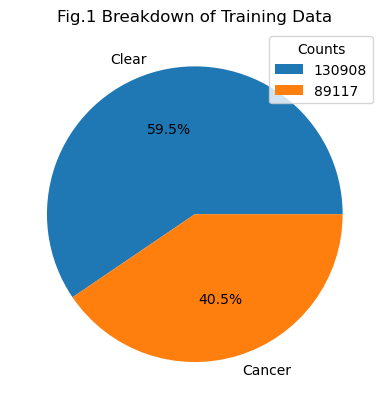

In [8]:
# create a size count for the plot
sizes = train_labels['label'].value_counts()

# create label names for binary classification
mapping = {0 : 'Clear', 1 : 'Cancer'}
labels = [mapping[binary] for binary in sizes.index]

# visualize the make-up of the training data
fig, ax = plt.subplots()
wedges, _, _, = ax.pie(sizes, labels= labels, autopct = '%1.1f%%')
ax.set_title('Fig.1 Breakdown of Training Data')
# add counts as legend
ax.legend(wedges, [f"{count}" for count in sizes.values], title="Counts")

Based on Fig.1 we can conclude that there are enough samples of both categories present. Large sample counts compensate for the slight imbalance in destribution.

Now we will inspect the training images.

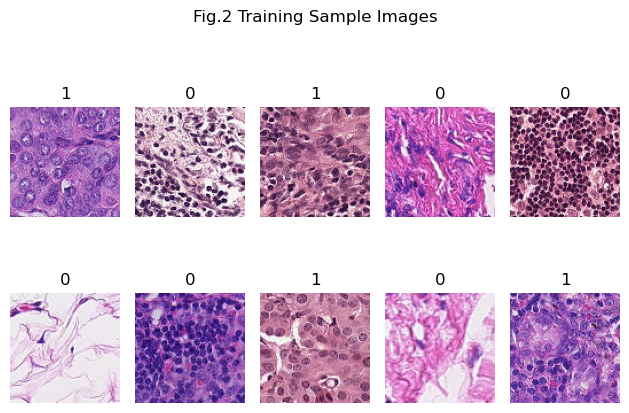

In [9]:
# select 10 random ids
random.seed(50)
random_sample = random.sample(os.listdir(train_path), 10)
indexed_label = train_labels.set_index('id')['label']
# plot the samples with their label
plt.figure()

for i, name in enumerate(random_sample):
    image_path = os.path.join(train_path, name)
    sample_image = Image.open(image_path)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_image)
    plt.title(indexed_label[os.path.splitext(name)[0]])
    plt.axis('off')
plt.suptitle('Fig.2 Training Sample Images')
plt.tight_layout()
plt.show()

### 2.3- Preprocessing

First we will split the provided training images into training and testing sets so we can tweak the model on labeled data if necessary before evaluating it on the unlabeled test data from kaggle. It is important to check the splits to make sure the distribution of samples is within an acceptable range and not unbalanced. we will not artificially adjust the distributions as cancereous images (and patients) are less likely and less common compared to non-cancerous counterparts. The model should be able to learn to detect cancer from a reletively smaller sample size. Similarly, we will not stratify the split, as we do not want our model to "assume" that distributions are always at a constant rate and overfit.

In [10]:
# split training_data into training and validation set
df_train, df_val = train_test_split(train_labels, test_size= 0.2, random_state=50)
print("Training samples:", df_train.shape[0])
print("Validation samples:", df_val.shape[0])

Training samples: 176020
Validation samples: 44005


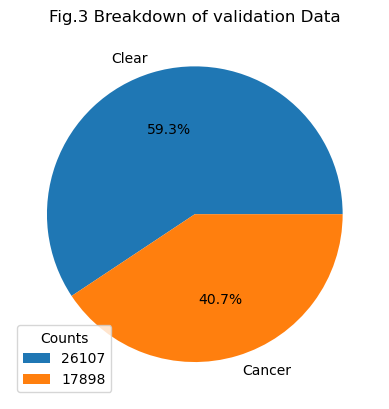

In [11]:
# making sure the validation set is not lobsided
sizes = df_val['label'].value_counts()

# create label names for binary classification
mapping = {0 : 'Clear', 1 : 'Cancer'}
labels = [mapping[binary] for binary in sizes.index]

# visualize the make-up of the training data
fig, ax = plt.subplots()
wedges, _, _, = ax.pie(sizes, labels= labels, autopct = '%1.1f%%')
ax.set_title('Fig.3 Breakdown of validation Data')
# add counts as legend
ax.legend(wedges, [f"{count}" for count in sizes.values], title="Counts")

We have confirmed that the testing split is balanced. This implies that our training set also follows a similar distribution. We can now procceed to the next part; creating the pipeline.
We will develop solutions to import, decode, resize and reformat the image data. Due to the limitations of the used Keras version, all images were converted from tif format to png. The png versions were used for this project. 
Since the images are in 8-bit color, they store values from 0 to 255. In the following section, we will normalize the 8-bit values such that the new values range from 0 to 1. We will also create a grayscale normalization so that we can compare RGB vs grayscale model performances. additionally, we will implement a third variation that crops the original image size down to 64x64 as the model is expected to find tumors in the 32x32 center square. This third implementation preserves the original center squares (with sufficient extra pixels around it) while cutting the total number of pixels that need to be processed in less than half. Finally, images are grouped into batches such that the batch size is optimized for system and model performance.

In [12]:
# load and prepare images
img_size = 96
crop_size = 64
batch_size = 64

def load_and_preprocess(filepath, label):
    img_bytes = tf.io.read_file(filepath) # read
    img = tf.image.decode_png(img_bytes, channels=3) #decode
    img = tf.image.resize(img, (img_size, img_size)) # set size
    img = tf.image.convert_image_dtype(img, tf.float32) # normalize
    return img, tf.cast(label, tf.int32)

# implement the three variations

def make_views_with_crop(filepath, label):
    img, label = load_and_preprocess(filepath, label)
    
    # 1- full size RGB
    rgb_96 = img
    
    # 2- full size grayscale
    gray_96 = tf.image.rgb_to_grayscale(img)
    
    # 3- center crop RGB
    offset = (img_size - crop_size) // 2
    center_64 = tf.image.crop_to_bounding_box(rgb_96, offset_height=offset, offset_width=offset, target_height=crop_size, target_width=crop_size)
    
    outputs = {"rgb_96": rgb_96, "gray_96": gray_96, "center_64": center_64}
    return outputs, label

# build file paths and labels from the dataframe
def dataframe_to_dataset(df, img_dir, batch_size = batch_size , shuffle= True):
    filepaths = df["id"].apply(lambda x: os.path.join(img_dir, x + ".png")).tolist()
    labels = df["label"].astype("int32").tolist()
    
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels)) # pair path and label 
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True) # shuffle for each epochs
        
    ds = ds.map(make_views_with_crop, num_parallel_calls=tf.data.AUTOTUNE) # maximize gpu performance
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) # batching images
    return ds
    

In [13]:
# run the functions on training and validation images
train_multi_ds = dataframe_to_dataset(df_train, train_path, shuffle=True)
val_multi_ds = dataframe_to_dataset(df_val, train_path, shuffle=False)

In [14]:
# function to separate the different datasets

def select_view(ds, view_key):
    return ds.map(lambda views, label: (views[view_key], label), num_parallel_calls= tf.data.AUTOTUNE)


# run the function

train_rgb_ds = select_view(train_multi_ds, "rgb_96")
val_rgb_ds = select_view(val_multi_ds, "rgb_96")

train_gray_ds = select_view(train_multi_ds, "gray_96")
val_gray_ds = select_view(val_multi_ds, "gray_96")

train_center_ds = select_view(train_multi_ds, "center_64")
val_center_ds = select_view(val_multi_ds, "center_64")

## 3- Model Selection and Architecture

### 3.1- Model 1: Full Size RGB Input

For the first model we will use a custom "GoogleLeNet" style architecture. This model is suitable for this project as the architecture offers parallel convolutions that capture features at different scales, and the 1x1 convolutions layer at the beginning reduces feature map depth which helps with computational efficiency. This architectue also balances depth and width, which enables deeper networks with reduced momory load. This implementation combines parallel branches of 1×1 convolutions for channel mixing, 3×3 convolutions for local texture modeling, deeper 3×3 stacks for broader contextual understanding, and a pooling branch for robust, smoothed representations. After the final block, global average pooling condenses all feature maps into a single response, enabling the network to identify cancer presence anywhere in the patch, while dropout improves generalization and prevents overfitting.

### 3.2- Model 2: Full Size Grayscale Input

For the second model, I used a straightforward convolutional architecture designed specifically for grayscale input, making it computationally lighter while still capable of extracting meaningful hierarchical features. This model progressively increases the number of filters across stacked 3×3 convolutional layers, allowing it to learn low-level edges and textures in early layers and more complex structural patterns deeper in the network. Each convolution block is followed by max-pooling, which reduces spatial resolution and keeps the model efficient while retaining the most informative activations. After several stages of downsampling, the feature maps are flattened and passed through a dense layer that consolidates high-level representations useful for distinguishing cancerous from non-cancerous tiles. A dropout layer adds regularization to prevent overfitting, and the final sigmoid output unit produces the binary cancer prediction. This simple yet effective architecture provides a strong baseline for grayscale histopathology analysis while maintaining low computational overhead.

### 3.3- Model 3: Cropped RGB Input

For the third model, I used a compact convolutional network designed specifically for center-cropped 64×64 RGB patches, allowing the model to focus on the most informative region of each tile while keeping computational cost low. The architecture follows a simple hierarchical pattern, beginning with a 3×3 convolutional layer and progressively increasing the number of filters to capture increasingly complex visual features. Each convolutional layer is paired with max-pooling, which reduces spatial dimensions, retains salient information, and helps the network generalize by introducing translational robustness. After the final convolution block, the feature maps are flattened and passed into a dense layer that synthesizes high-level representations crucial for identifying subtle tumor characteristics within the crop. A dropout layer provides regularization to prevent overfitting, and a sigmoid output node produces the final binary prediction. This streamlined architecture is well suited for efficiently learning from smaller, focused image crops while maintaining strong discriminative ability.



In [15]:
# define architecture layout
def inception_block(x,
                    f1x1,
                    f3x3_reduce, f3x3,
                    f5x5_reduce, f5x5,
                    f_pool):
    # 1x1 branch
    branch1 = layers.Conv2D(f1x1, (1, 1), padding="same", activation="relu")(x)

    # 1x1 -> 3x3 branch
    branch2 = layers.Conv2D(f3x3_reduce, (1, 1), padding="same", activation="relu")(x)
    branch2 = layers.Conv2D(f3x3, (3, 3), padding="same", activation="relu")(branch2)

    # 1x1 -> (3x3 -> 3x3) branch
    branch3 = layers.Conv2D(f5x5_reduce, (1, 1), padding="same", activation="relu")(x)
    branch3 = layers.Conv2D(f5x5, (3, 3), padding="same", activation="relu")(branch3)
    branch3 = layers.Conv2D(f5x5, (3, 3), padding="same", activation="relu")(branch3)

    # pooling branch
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
    branch4 = layers.Conv2D(f_pool, (1, 1), padding="same", activation="relu")(branch4)

    # concatenate along channels
    x = layers.Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return x

def build_rgb_model():
    inputs = layers.Input(shape=(96, 96, 3), name="rgb_96_input")

    # stem
    x = layers.Conv2D(32, (3, 3), strides=1, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)   # 48x48

    # inception block 1
    x = inception_block(
        x,
        f1x1=32,
        f3x3_reduce=32, f3x3=48,
        f5x5_reduce=8,  f5x5=16,
        f_pool=16
    )
    x = layers.MaxPooling2D((2, 2))(x)   # 24x24

    # inception block 2
    x = inception_block(
        x,
        f1x1=64,
        f3x3_reduce=48, f3x3=64,
        f5x5_reduce=12, f5x5=24,
        f_pool=24
    )
    x = layers.MaxPooling2D((2, 2))(x)   # 12x12

    # inception block 3
    x = inception_block(
        x,
        f1x1=64,
        f3x3_reduce=64, f3x3=96,
        f5x5_reduce=16, f5x5=32,
        f_pool=32
    )

    # global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="inception_rgb_96")
    return model

In [16]:
rgb_model = build_rgb_model()
rgb_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
epochs = 10
history_rgb = rgb_model.fit(train_rgb_ds, validation_data= val_rgb_ds, epochs=epochs)

Epoch 1/10
2751/2751 [==============================] - 85s 28ms/step - loss: 0.5432 - accuracy: 0.8004 - auc: 0.8644 - val_loss: 0.3522 - val_accuracy: 0.8466 - val_auc: 0.9226
Epoch 2/10
2751/2751 [==============================] - 77s 28ms/step - loss: 0.3390 - accuracy: 0.8568 - auc: 0.9254 - val_loss: 0.2894 - val_accuracy: 0.8766 - val_auc: 0.9508
Epoch 3/10
2751/2751 [==============================] - 78s 28ms/step - loss: 0.2887 - accuracy: 0.8816 - auc: 0.9458 - val_loss: 0.2643 - val_accuracy: 0.8894 - val_auc: 0.9610
Epoch 4/10
2751/2751 [==============================] - 77s 28ms/step - loss: 0.2515 - accuracy: 0.9003 - auc: 0.9585 - val_loss: 0.2491 - val_accuracy: 0.8958 - val_auc: 0.9646
Epoch 5/10
2751/2751 [==============================] - 76s 28ms/step - loss: 0.2230 - accuracy: 0.9135 - auc: 0.9670 - val_loss: 0.3319 - val_accuracy: 0.8462 - val_auc: 0.9648
Epoch 6/10
2751/2751 [==============================] - 79s 29ms/step - loss: 0.2051 - accuracy: 0.9218 - auc:

In [17]:
def build_gray_model():
    inputs = layers.Input(shape=(96,96,1), name="gray_96_input")
    
    x = layers.Conv2D(16, (3,3), activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(32, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(256, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    
    # flatten feature maps for fully connected classification layer
    x = layers.Flatten()(x)
    # dense layer to combine extracted features
    x = layers.Dense(256, activation="relu")(x)
    # dropout for regularization and reduced overfitting
    x = layers.Dropout(0.25)(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="gray_96_model")
    
    return model

In [18]:
gray_model = build_gray_model()
gray_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
epochs = 10
history_gray = gray_model.fit(train_gray_ds, validation_data= val_gray_ds, epochs=epochs)

Epoch 1/10
2751/2751 [==============================] - 41s 14ms/step - loss: 0.4741 - accuracy: 0.7878 - auc: 0.8536 - val_loss: 0.4220 - val_accuracy: 0.8077 - val_auc: 0.8923
Epoch 2/10
2751/2751 [==============================] - 38s 14ms/step - loss: 0.3801 - accuracy: 0.8349 - auc: 0.9049 - val_loss: 0.3501 - val_accuracy: 0.8492 - val_auc: 0.9199
Epoch 3/10
2751/2751 [==============================] - 41s 15ms/step - loss: 0.3426 - accuracy: 0.8536 - auc: 0.9231 - val_loss: 0.3239 - val_accuracy: 0.8590 - val_auc: 0.9326
Epoch 4/10
2751/2751 [==============================] - 40s 15ms/step - loss: 0.3147 - accuracy: 0.8686 - auc: 0.9351 - val_loss: 0.3272 - val_accuracy: 0.8584 - val_auc: 0.9345
Epoch 5/10
2751/2751 [==============================] - 40s 14ms/step - loss: 0.2927 - accuracy: 0.8793 - auc: 0.9439 - val_loss: 0.2963 - val_accuracy: 0.8761 - val_auc: 0.9430
Epoch 6/10
2751/2751 [==============================] - 40s 14ms/step - loss: 0.2744 - accuracy: 0.8879 - auc:

In [19]:
def build_center_model():
    inputs = layers.Input(shape=(64,64,3), name="center_64_input")
    
    x = layers.Conv2D(32, (3,3), activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    
    # flatten feature maps for fully connected classification layer
    x = layers.Flatten()(x)
    # dense layer to combine extracted features
    x = layers.Dense(128, activation="relu")(x)
    # dropout for regularization and reduced overfitting
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="center_64_model")
    
    return model

In [20]:
center_model = build_center_model()
center_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
epochs = 10
history_center = center_model.fit(train_center_ds, validation_data= val_center_ds, epochs=epochs)

Epoch 1/10
2751/2751 [==============================] - 36s 13ms/step - loss: 0.6100 - accuracy: 0.7721 - auc: 0.8358 - val_loss: 0.4688 - val_accuracy: 0.7942 - val_auc: 0.8678
Epoch 2/10
2751/2751 [==============================] - 35s 13ms/step - loss: 0.4347 - accuracy: 0.8055 - auc: 0.8742 - val_loss: 0.4103 - val_accuracy: 0.8170 - val_auc: 0.8926
Epoch 3/10
2751/2751 [==============================] - 35s 13ms/step - loss: 0.4056 - accuracy: 0.8231 - auc: 0.8910 - val_loss: 0.3712 - val_accuracy: 0.8371 - val_auc: 0.9100
Epoch 4/10
2751/2751 [==============================] - 35s 13ms/step - loss: 0.3827 - accuracy: 0.8345 - auc: 0.9034 - val_loss: 0.3843 - val_accuracy: 0.8347 - val_auc: 0.9162
Epoch 5/10
2751/2751 [==============================] - 35s 13ms/step - loss: 0.3608 - accuracy: 0.8454 - auc: 0.9147 - val_loss: 0.3439 - val_accuracy: 0.8506 - val_auc: 0.9245
Epoch 6/10
2751/2751 [==============================] - 36s 13ms/step - loss: 0.3431 - accuracy: 0.8540 - auc:

## 4- Results and Analysis

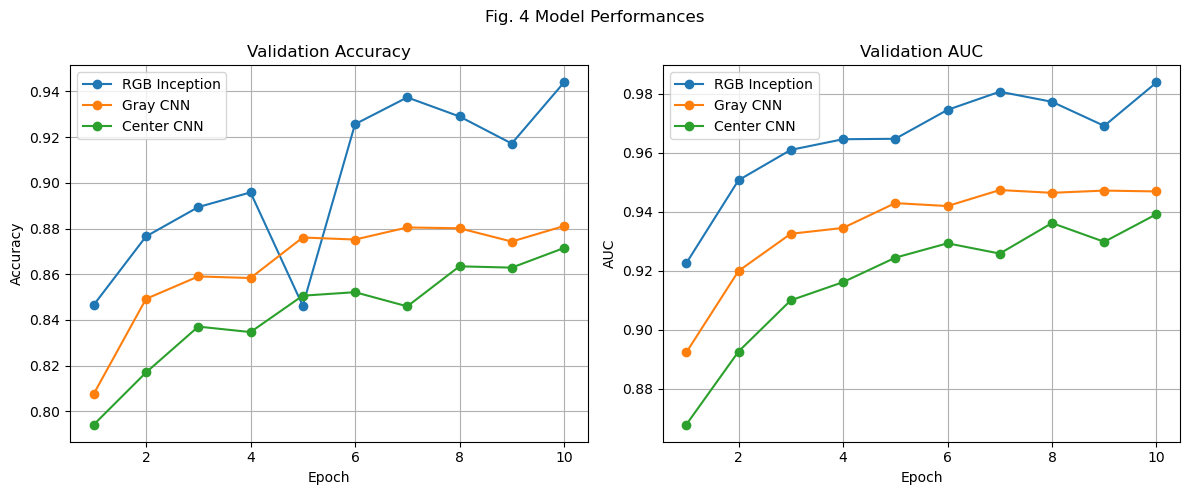

In [25]:
# extract validation metrics from the history objects
rgb_val_acc = history_rgb.history["val_accuracy"]
rgb_val_auc = history_rgb.history["val_auc"]

gray_val_acc = history_gray.history["val_accuracy"]
gray_val_auc = history_gray.history["val_auc"]

center_val_acc = history_center.history["val_accuracy"]
center_val_auc = history_center.history["val_auc"]

# use the number of epochs from histories
epochs_rgb = range(1, len(rgb_val_acc) + 1)
epochs_gray = range(1, len(gray_val_acc) + 1)
epochs_center = range(1, len(center_val_acc) + 1)

plt.figure(figsize=(12, 5))

# plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_rgb, rgb_val_acc, marker="o", label="RGB Inception")
plt.plot(epochs_gray, gray_val_acc, marker="o", label="Gray CNN")
plt.plot(epochs_center, center_val_acc, marker="o", label="Center CNN")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# plot validation auc
plt.subplot(1, 2, 2)
plt.plot(epochs_rgb, rgb_val_auc, marker="o", label="RGB Inception")
plt.plot(epochs_gray, gray_val_auc, marker="o", label="Gray CNN")
plt.plot(epochs_center, center_val_auc, marker="o", label="Center CNN")
plt.title("Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()

plt.suptitle("Fig. 4 Model Performances")
plt.tight_layout()
plt.show()


### 4.1- Visual Analysis

The rgb model shows some variability in accuracy and auc as epochs increase, but the overall trend shows it performs the best on the test data. Further optimization can help smooth out the inconsistencies. The significant drop in accuracy at the fifth epoch can be ignored as the auc plot shows no significant negative change. Since the Kaggle competition measures the performances of models using the auc metric, we will also prioritize this metric. This model might benefit from increasing the epoch count. The validation accuracy peaked at 94.39% while the validation auc reached 98.39%.

The grayscale model appears to be the most stable and optimized. This is expected as I spent more time optimizing the gray model. The gray model performs well compared to the rgb model but falls 4% shorter on the validation auc metric. The validation auc and auc also shows that the gray model will not benefit from more epochs. The model reached validation accuracy reached 88.11% while the validation auc reached 94.69% at the tenth epoch.

The center model performed the worst but still managed to surpass 90% on the auc metric. This was to be expected as the input as dimensionally reduced and the model was the simplest and I did not spend a lot of time on optimizing it. Regardless, we see that the accuracy and auc metrics improve as epochs increase. The plots indicate this model might perform better with increasing epochs as well as further optimization and increased depth. The model reached validation accuracy reached 87.15% while the validation auc reached 93.92% at the tenth epoch.

### 4.2- Temporal Analysis

The rgb model took the longest to train, averaging 78 seconds per epoch. The gray model averaged 40 seconds per epoch and the center model took the shortest at an average of 35.6 seconds. This means training the gray model was 1.95 faster than the rgb model while training the center model was 2.19 times faster than the rgb model.

### 4.3- Hyperparameter Tuning

for all models I tried different values for the the dropout rates, epoch and learning rate. Unless a custom value offered significantly better performance, the same value was used across the board to maintain comparability. Using a dynamic value for learning rate did not further improve the results. 

### 4.4- Kaggle results

Now that we have tested the data on our test data that we split from the provided labled data, it's time to predict values for the Kaggle testing data and submit the produced csv files to Kaggle.

In [22]:
# rgb prediction
df_test = pd.DataFrame({'id':os.listdir(test_path)})
df_test['id'] = df_test['id'].str.split('.').str[0]
df_test['label'] = 1
test_multi_ds = dataframe_to_dataset(df_test, test_path, shuffle=False)
test_rgb_ds = select_view(test_multi_ds, "rgb_96")
prediction_rgb = rgb_model.predict(test_rgb_ds, verbose=1)

submission = pd.DataFrame({"id": df_test["id"], "label": prediction_rgb.ravel()})
submission.to_csv('submission_rgb.csv', index=False)
submission.head()

898/898 [==============================] - 9s 10ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1.000000
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.994141
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.999023
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.000042
4,000270442cc15af719583a8172c87cd2bd9c7746,0.007092


In [23]:
# gray prediction
df_test = pd.DataFrame({'id':os.listdir(test_path)})
df_test['id'] = df_test['id'].str.split('.').str[0]
df_test['label'] = 1
test_multi_ds = dataframe_to_dataset(df_test, test_path, shuffle=False)
test_gray_ds = select_view(test_multi_ds, "gray_96")
prediction_gray = gray_model.predict(test_gray_ds, verbose=1)

submission = pd.DataFrame({"id": df_test["id"], "label": prediction_gray.ravel()})
submission.to_csv('submission_gray.csv', index=False)
submission.head()

898/898 [==============================] - 8s 9ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.990234
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.996094
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.957031
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.979980
4,000270442cc15af719583a8172c87cd2bd9c7746,0.031006


In [24]:
# center prediction
df_test = pd.DataFrame({'id':os.listdir(test_path)})
df_test['id'] = df_test['id'].str.split('.').str[0]
df_test['label'] = 1
test_multi_ds = dataframe_to_dataset(df_test, test_path, shuffle=False)
test_center_ds = select_view(test_multi_ds, "center_64")
prediction_center = center_model.predict(test_center_ds, verbose=1)

submission = pd.DataFrame({"id": df_test["id"], "label": prediction_center.ravel()})
submission.to_csv('submission_center.csv', index=False)
submission.head()

898/898 [==============================] - 8s 9ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.999023
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.877441
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.422119
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.742676
4,000270442cc15af719583a8172c87cd2bd9c7746,0.009300


![Kaggle Results](kaggle_scores.jpg)

The results are unexpected. The gray model performs the best according to the private score, which is the majority of the test sample. The gray model scored 91.28% (private) and 91.38% (public). These results are close to our internal auc score of 94.69% which indicate the model is consistent and well trained.

The center model performed the worst, scoring 88.23% and 91.16% on private and public sets respectively. These results are close to internal auc result of 93.92% but the public score is over 5% under the internal value. Considering the simplicity of the model design and the reduced dimensions of the input, the model's performance is acceptable.

The rgb model's performance is unexpected. This model scored 90.83% on private set and 94.30% on the public set. The private score is significantly lower than the public score as well as the internal auc score of 98.39%. Considering the complexity of the model and the training time, this model was expected to perform better, however since the model surpassed 90% on both kaggle testing sets, it cannot be considered a failure.

## 5- Conclusion

The comparative evaluation of the three convolutional models shows the tradeoffs between architectural complexity, input representation, and practical performance in histopathologic cancer detection. Although the rgb model achieved the best internal validation performance, with a peak validation AUC of 98.39%, its results did not translate as reliably to the Kaggle private test set, where it scored 90.83%. This gap suggests that the model may have been more sensitive to distribution shifts or subtle overfitting despite its strong theoretical capacity for multi-scale feature extraction. The grayscale model, however, demonstrated the most stable training behavior and produced consistent results across internal validation and Kaggle evaluation. Its private score of 91.28% closely compares to its internal AUC of 94.69%, indicating that the model generalized well despite using only single-channel input. This supports the idea that color information, while useful, is not strictly necessary for capturing the structural patterns relevant to metastasis detection in these tiles. Finally, the center model performed as expected for a lightweight architecture operating on reduced spatial input. Although it achieved the lowest private score at 88.23%, its results remain reasonable given its simplicity and faster training time.

Increasing the depth on the gray model helped improve the performance by about 2% on the Kaggle private set. Different dropout rates were tried but the effect was not positively significant. Dynamically changing the learning rate did not help increase the performance model either.

Overall, the results show that architectural complexity alone does not guarantee superior real-world performance. Instead, model stability, generalization behavior, and robustness to dataset variability appear equally important. The grayscale model emerged as the best overall performer due to its balanced accuracy, consistency, and efficiency. Meanwhile, the RGB Inception model shows promise but may require additional regularization, tuning, or data augmentation to create more consistent external test results with the internal metrics. The center model, despite being limited, offers a viable low cost baseline and could benefit from deeper architecture or larger input regions. Collectively, these findings emphasize the importance of evaluating models not only by internal metrics but also by their ability to generalize across different subsets of real pathology data.
